# Explainable Machine Learning for Identifying Lifestyle Factors Contributing to Diabetes Risk

**Author(s)**:
- Sumit Barua
- Sohaib Jabran
- Charles Barnabas Rodgers

**Dataset Overview**:
- Source: [CDC BRFSS 2024 survey](https://www.cdc.gov/brfss/annual_data/annual_2024.html)

---

### 1. Importing and installing the required packagaes and classes for this project

**1.1 Installing Packages**

In [8]:
!pip -q install xgboost shap imbalanced-learn

**1.2 Importing Necessary Dependencies**

In [9]:
import warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
)

from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import pickle

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)
sns.set_context("talk")

## 2. Load dataset

In [10]:
DATA_PATH = "dataset/final_2024_dataset/brfss2024_modelready_scaled_with_state.csv"

# Creating a pandas dataframe
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head(3)

(453241, 122)


,num___PHYS14D,num__ALCDAY4,num__AVEDRNK4,num__DRNK3GE5,num__PHYSHLTH,num__MENTHLTH,num__POORHLTH,num___BMI5,num__WEIGHT2,cat__EXERANY2_1.0,...,cat__INCOME3_3.0,cat__INCOME3_4.0,cat__INCOME3_5.0,cat__INCOME3_6.0,cat__INCOME3_10.0,cat__INCOME3_11.0,target_3class,SEQNO,State_Code,State_Name
0,1.316389,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,5.552593,0.246029,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,b'2024000421',NaN,NaN
1,2.632778,2.114224,1.04570,0.710436,0.225558,0.722539,0.0,4.949120,0.276635,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,b'2024007291',6.0,California
2,3.949168,1.057112,0.52285,0.710436,3.383376,0.361270,0.0,4.479751,0.223663,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,b'2024012918',55.0,Wisconsin


# 3. Define feature groups & helper to collect encoded columns

In [11]:
behavioral_codes = [
    "EXERANY2","_PHYS14D",
    "SMOKE100","SMOKDAY2","_SMOKER3","_RFSMOK3",
    "ALCDAY4","AVEDRNK4","DRNK3GE5","DRNKANY6",
    "GENHLTH","PHYSHLTH","MENTHLTH","POORHLTH",
    "Unhealthy_Days_Total","Alcohol_Risk_Level"
]

demographic_codes = ["SEXVAR","_AGE80","_RACEGR3","EDUCA","INCOME3"]
anthro_codes      = ["_BMI5","WEIGHT2","_RFBMI5","_BMI5CAT"]

meta_cols = ["target_3class","SEQNO","State_Code","State_Name"]

def collect_encoded(df, bases):
    cols = []
    for b in bases:
        n = f"num__{b}"
        if n in df.columns: cols.append(n)
        cols += [c for c in df.columns if c.startswith(f"cat__{b}_")]
    return sorted(set(cols))

X1_cols = collect_encoded(df, behavioral_codes)
X2_cols = sorted(set(X1_cols) |
                 set(collect_encoded(df, demographic_codes)) |
                 set(collect_encoded(df, anthro_codes)))

X1_cols = [c for c in X1_cols if c not in meta_cols] # For Model-1
X2_cols = [c for c in X2_cols if c not in meta_cols] # For Model-2

# Modifiable features
print("Model-1 (behavioral) features:", len(X1_cols))

# Modifiable + Demographic features
print("Model-2 (behavioral+demo+anthro) features:", len(X2_cols))

Model-1 (behavioral) features: 27
Model-2 (behavioral+demo+anthro) features: 118


# 4. Build X and y for Both Specification

In [12]:
# Target: 0 - No Diabetes, 1 - Prediabetes, 2 - Diabetes
y = df["target_3class"].astype(int)

# Defining the predictors
# Model-1
X1 = df[X1_cols].copy()
# Model-2
X2 = df[X2_cols].copy()

# State columns not needed for model prediction
state_series = df["State_Name"].copy() if "State_Name" in df.columns else pd.Series(index=df.index, dtype="object")

In [13]:
# Build X matrices and ensure numeric
def to_numeric_frame(df, cols):
    X = df[cols].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)

X1 = to_numeric_frame(df, X1_cols)
X2 = to_numeric_frame(df, X2_cols)

print("X1 shape: ", X1.shape)
print("X2 shape: ", X2.shape)

X1 shape:  (453241, 27)
X2 shape:  (453241, 118)


# 5. Stratified Train/Test Split

In [14]:
# Performed stratified splitting to ensure that dataset's class proportions are maintained

# Model-1
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y, test_size=0.2, stratify=y, random_state=42
)
# Model-2
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2, stratify=y, random_state=42
)

print("Shapes M1:", X1_train.shape, X1_test.shape)
print("Shapes M2:", X2_train.shape, X2_test.shape)

Shapes M1: (362592, 27) (90649, 27)
Shapes M2: (362592, 118) (90649, 118)


# 6. Class rebalancing (SMOTE on training sets only)

target_3class
0    82.985560
2    14.519625
1     2.494815
Name: proportion, dtype: float64


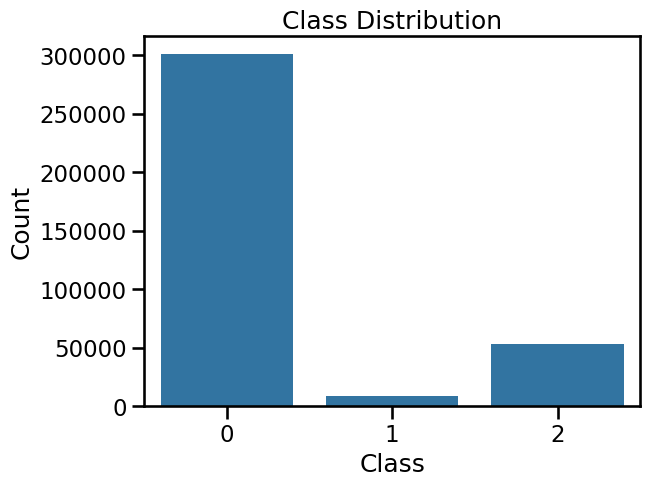

In [ ]:
# Checked the normalized class distribution
count_classes = y1_train.value_counts(normalize=True)
# Percentage
print(f'{count_classes * 100}')

# Plotting and visualizing the classess
plt.title("Class Distribution")
sns.countplot(x=y1_train)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [16]:
# Performing SMOTE - Plain
# Generated between all minority samples

from collections import Counter

# Only oversample classes 1 and 2
smote = SMOTE(
    random_state=42,
    sampling_strategy="not majority"     # do NOT oversample class 0
)

X1_tr_sm, y1_tr_sm = smote.fit_resample(X1_train, y1_train)
X2_tr_sm, y2_tr_sm = smote.fit_resample(X2_train, y2_train)

print("Before M2:", Counter(y2_train))
print("After M2:", Counter(y2_tr_sm))

Before M2: Counter({0: 300899, 2: 52647, 1: 9046})
After M2: Counter({0: 300899, 1: 300899, 2: 300899})


# 9. Evaluation Utility

In [5]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="", average="macro"):
    print(f"\n=== {name} ===")
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)

    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred)
    print("Confusion matrix:\n", cm)

    try:
        roc_auc = roc_auc_score(y_te, y_proba, multi_class="ovr", average=average)
    except Exception:
        roc_auc = np.nan
    print(f"ROC-AUC ({average}): {roc_auc:.3f}")

    # Simple scalar metrics for comparison table
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="weighted")
    prec = precision_score(y_te, y_pred, average="weighted")
    rec = recall_score(y_te, y_pred, average="weighted")

    return {"Model": name, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1": f1, "ROC-AUC": roc_auc}


# 10. Logistic Regression (Model-1)

In [17]:
results = []

logreg1 = LogisticRegression(
    max_iter=2000, multi_class="ovr", class_weight="balanced", n_jobs=-1
)
results.append(
    evaluate_model(logreg1, X1_tr_sm, y1_tr_sm, X1_test, y1_test,
                   name="Logistic Regression — Model-1")
)



=== Logistic Regression — Model-1 ===

Classification report:
              precision    recall  f1-score   support

           0      0.909     0.618     0.736     75226
           1      0.033     0.184     0.056      2261
           2      0.269     0.551     0.362     13162

    accuracy                          0.598     90649
   macro avg      0.404     0.451     0.385     90649
weighted avg      0.795     0.598     0.665     90649

Confusion matrix:
 [[46527  9975 18724]
 [  872   417   972]
 [ 3762  2144  7256]]
ROC-AUC (macro): 0.682


# 11. Logistic Regression (Model-2)

In [18]:
logreg2 = LogisticRegression(
    max_iter=2000, multi_class="ovr", class_weight="balanced", n_jobs=-1
)
results.append(
    evaluate_model(logreg2, X2_tr_sm, y2_tr_sm, X2_test, y2_test,
                   name="Logistic Regression — Model-2")
)



=== Logistic Regression — Model-2 ===

Classification report:
              precision    recall  f1-score   support

           0      0.938     0.638     0.759     75226
           1      0.047     0.306     0.081      2261
           2      0.305     0.574     0.399     13162

    accuracy                          0.620     90649
   macro avg      0.430     0.506     0.413     90649
weighted avg      0.824     0.620     0.690     90649

Confusion matrix:
 [[47968 10940 16318]
 [  688   692   881]
 [ 2504  3102  7556]]
ROC-AUC (macro): 0.749


# 12. Decision Tree (Model-1)

In [19]:
dt1 = DecisionTreeClassifier(
    max_depth=8, min_samples_leaf=100, class_weight="balanced", random_state=42
)
results.append(
    evaluate_model(dt1, X1_tr_sm, y1_tr_sm, X1_test, y1_test,
                   name="Decision Tree — Model-1")
)


=== Decision Tree — Model-1 ===

Classification report:
              precision    recall  f1-score   support

           0      0.906     0.634     0.746     75226
           1      0.025     0.060     0.035      2261
           2      0.257     0.635     0.366     13162

    accuracy                          0.620     90649
   macro avg      0.396     0.443     0.382     90649
weighted avg      0.790     0.620     0.673     90649

Confusion matrix:
 [[47695  4577 22954]
 [  914   136  1211]
 [ 4043   764  8355]]
ROC-AUC (macro): 0.671


# 13. Decision Tree (Model-2)

In [20]:
dt2 = DecisionTreeClassifier(
    max_depth=8, min_samples_leaf=100, class_weight="balanced", random_state=42
)
results.append(
    evaluate_model(dt2, X2_tr_sm, y2_tr_sm, X2_test, y2_test,
                   name="Decision Tree — Model-2")
)


=== Decision Tree — Model-2 ===

Classification report:
              precision    recall  f1-score   support

           0      0.896     0.742     0.811     75226
           1      0.054     0.103     0.071      2261
           2      0.289     0.529     0.374     13162

    accuracy                          0.695     90649
   macro avg      0.413     0.458     0.419     90649
weighted avg      0.787     0.695     0.729     90649

Confusion matrix:
 [[55782  3230 16214]
 [ 1112   233   916]
 [ 5383   816  6963]]
ROC-AUC (macro): 0.692


# 14. Random Forest (Model-1)

In [ ]:
rf1 = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_leaf=50, class_weight="balanced", n_jobs=-1, random_state=42
)
results.append(
    evaluate_model(rf1, X1_tr_sm, y1_tr_sm, X1_test, y1_test,
                   name="Random Forest — Model-1")
)


=== Random Forest — Model-1 ===

Classification report:
              precision    recall  f1-score   support

           0      0.905     0.654     0.759     75226
           1      0.031     0.097     0.046      2261
           2      0.265     0.587     0.365     13162

    accuracy                          0.630     90649
   macro avg      0.400     0.446     0.390     90649
weighted avg      0.790     0.630     0.684     90649

Confusion matrix:
 [[49165  5693 20368]
 [  988   219  1054]
 [ 4168  1268  7726]]
ROC-AUC (macro): 0.667


# 15. Random Forest (Model-2)

In [22]:
rf2 = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_leaf=50, class_weight="balanced", n_jobs=-1, random_state=42
)
results.append(
    evaluate_model(rf2, X2_tr_sm, y2_tr_sm, X2_test, y2_test,
                   name="Random Forest — Model-2")
)


=== Random Forest — Model-2 ===

Classification report:
              precision    recall  f1-score   support

           0      0.892     0.815     0.851     75226
           1      0.060     0.032     0.042      2261
           2      0.326     0.514     0.399     13162

    accuracy                          0.751     90649
   macro avg      0.426     0.453     0.431     90649
weighted avg      0.789     0.751     0.766     90649

Confusion matrix:
 [[61277   859 13090]
 [ 1313    72   876]
 [ 6121   277  6764]]
ROC-AUC (macro): 0.718


# 16. XGBoost (Model-1)

In [ ]:
from xgboost import XGBClassifier
xgb1 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    class_weight = "balanced",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)
results.append(
    evaluate_model(xgb1, X1_tr_sm, y1_tr_sm, X1_test, y1_test,
                   name="XGBoost — Model-1")
)


=== XGBoost — Model-1 ===

Classification report:
              precision    recall  f1-score   support

           0      0.892     0.731     0.803     75226
           1      0.025     0.016     0.020      2261
           2      0.271     0.568     0.367     13162

    accuracy                          0.689     90649
   macro avg      0.396     0.438     0.397     90649
weighted avg      0.780     0.689     0.720     90649

Confusion matrix:
 [[54979  1138 19109]
 [ 1209    36  1016]
 [ 5444   243  7475]]
ROC-AUC (macro): 0.655


# 17. XGBoost (Model-2)

In [24]:
xgb2 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    class_weight = "balanced",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)
results.append(
    evaluate_model(xgb2, X2_tr_sm, y2_tr_sm, X2_test, y2_test,
                   name="XGBoost — Model-2")
)


=== XGBoost — Model-2 ===

Classification report:
              precision    recall  f1-score   support

           0      0.882     0.879     0.880     75226
           1      0.077     0.000     0.001      2261
           2      0.375     0.447     0.408     13162

    accuracy                          0.794     90649
   macro avg      0.445     0.442     0.430     90649
weighted avg      0.788     0.794     0.790     90649

Confusion matrix:
 [[66095     8  9123]
 [ 1588     1   672]
 [ 7279     4  5879]]
ROC-AUC (macro): 0.728


# 20. Model Spec Comparison

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,Algo,Spec
7,XGBoost — Model-2,0.793997,0.788078,0.793997,0.789639,0.727837,XGBoost,Model-2
5,Random Forest — Model-2,0.751393,0.788939,0.751393,0.765569,0.717549,Random Forest,Model-2
3,Decision Tree — Model-2,0.694746,0.786633,0.694746,0.729365,0.692459,Decision Tree,Model-2
6,XGBoost — Model-1,0.689362,0.780237,0.689362,0.720489,0.655217,XGBoost,Model-1
1,Logistic Regression — Model-2,0.620150,0.823573,0.620150,0.689823,0.748691,Logistic Regression,Model-2
4,Random Forest — Model-1,0.630012,0.790339,0.630012,0.684073,0.666855,Random Forest,Model-1
2,Decision Tree — Model-1,0.619819,0.789655,0.619819,0.673019,0.671291,Decision Tree,Model-1
0,Logistic Regression — Model-1,0.597911,0.794614,0.597911,0.664929,0.682006,Logistic Regression,Model-1



🌟 Best model by F1-score:
   XGBoost — Model-2
   Accuracy = 0.794
   F1-score = 0.790
   ROC-AUC  = 0.728


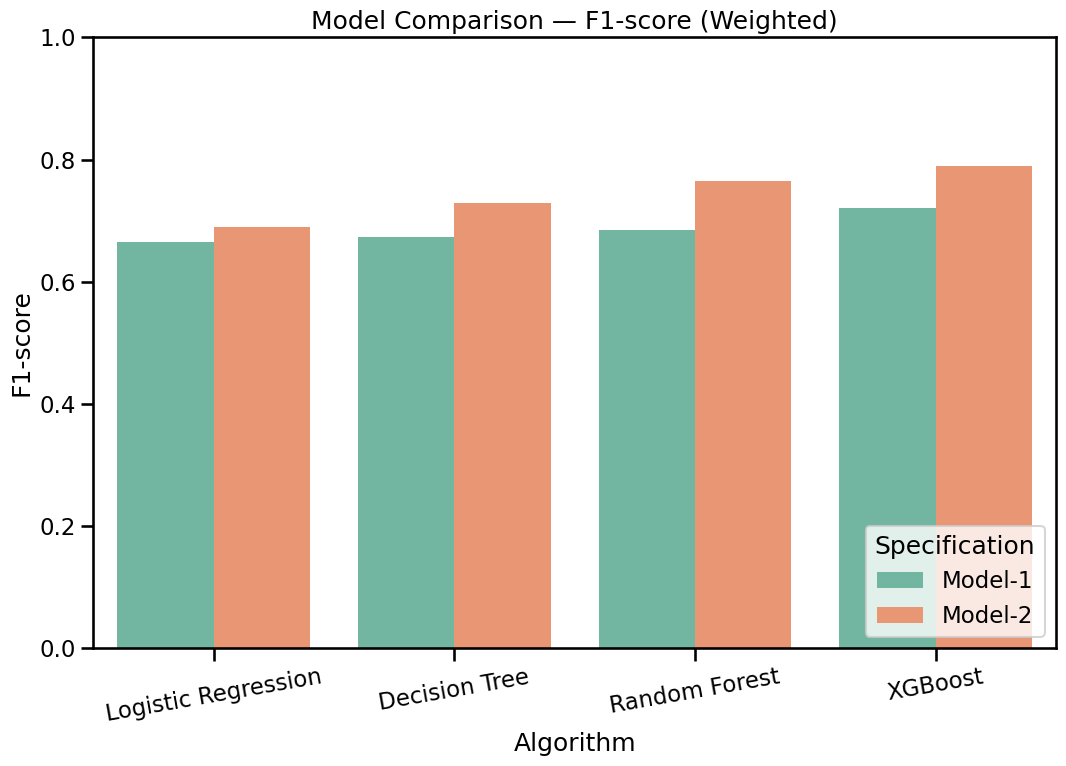

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Remove duplicated evaluations (keep last)
results_df_clean = results_df.drop_duplicates(subset=["Model"], keep="last").reset_index(drop=True)

# 2️⃣ Split Model label: "Algo — Model-1"
results_df_clean[["Algo", "Spec"]] = results_df_clean["Model"].str.split("—", expand=True)
results_df_clean["Algo"] = results_df_clean["Algo"].str.strip()
results_df_clean["Spec"] = results_df_clean["Spec"].str.strip()

# 3️⃣ Sort by F1 (best at top)
comparison_df = results_df_clean.sort_values("F1", ascending=False)
display(comparison_df)

# 4️⃣ Show best model clearly
best = comparison_df.iloc[0]
print(f"\n🌟 Best model by F1-score:")
print(f"   {best['Model']}")
print(f"   Accuracy = {best['Accuracy']:.3f}")
print(f"   F1-score = {best['F1']:.3f}")
print(f"   ROC-AUC  = {best['ROC-AUC']:.3f}")

# 5️⃣ Plot F1-score (weighted) by Algorithm × Specification
plt.figure(figsize=(11,8))
sns.barplot(
    data=results_df_clean,
    x="Algo",
    y="F1",
    hue="Spec",
    palette="Set2"
)

plt.title("Model Comparison — F1-score (Weighted)")
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.xlabel("Algorithm")
plt.legend(title="Specification", loc="lower right")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()



# Best Overall Model (XGBoost - Model: 2)

1. Best overall metrics from the above table (accuracy, F1, ROC-AUC) → most reliable predictions for a demo.

2. Great with SHAP: TreeExplainer is fast and gives clean global/local explanations.

3. Handles non-linearities (e.g., BMI × age × activity) better than LR/DT/RF.

4. Robust to missing: XGBoost can handle NaNs at inference if any field is skipped.

In [32]:
with open('best_model_overall.pkl', 'wb') as f:
    pickle.dump(xgb2, f)

# 21. SHAP Importance "stability" (top-k-overlap) between Model-1 and Model-2

In [25]:
# 21. SHAP Importance "stability" (top-k-overlap) between Model-1 and Model-2
import shap, numpy as np, pandas as pd

def mean_abs_shap_fast(model, X, class_index=2,
                        bg_size=1000, eval_size=3000):
    """
    Faster version:
    - Uses a small random subset of X for SHAP evaluation
    - Uses a smaller background sample
    """
    # 1) Sample rows for evaluation
    X_eval = X.sample(min(eval_size, len(X)), random_state=42)

    # 2) Background sample
    bg = X_eval.sample(min(bg_size, len(X_eval)), random_state=123)

    # 3) TreeExplainer
    explainer = shap.TreeExplainer(model, data=bg)
    sv = explainer(X_eval, check_additivity=False)
    values = sv.values

    # 4) Handle shapes (multi-class)
    if isinstance(values, list):
        values = values[class_index]
    elif values.ndim == 3:
        values = values[:, :, class_index]

    mean_abs = np.abs(values).mean(axis=0)
    return pd.Series(mean_abs, index=X_eval.columns).sort_values(ascending=False)

# Compute mean |SHAP| for both models using the fast version
m1_shap = mean_abs_shap_fast(xgb1, X1_test, class_index=2,
                             bg_size=800, eval_size=2500)
m2_shap = mean_abs_shap_fast(xgb2, X2_test, class_index=2,
                             bg_size=800, eval_size=2500)

def topk_overlap(s1, s2, k):
    top1 = set(s1.index[:k])
    top2 = set(s2.index[:k])
    return len(top1 & top2) / k

for k in [5, 10, 20, 30]:
    overlap = topk_overlap(m1_shap, m2_shap, k)
    print(f"Top-{k} overlap between Model-1 and Model-2: {overlap*100:.1f}%")

print("\nTop-15 features (Model-1):")
display(m1_shap.head(15))

print("\nTop-15 features (Model-2):")
display(m2_shap.head(15))


 99%|===================| 7451/7500 [02:29<00:00]       

Top-5 overlap between Model-1 and Model-2: 60.0%
Top-10 overlap between Model-1 and Model-2: 50.0%
Top-20 overlap between Model-1 and Model-2: 45.0%
Top-30 overlap between Model-1 and Model-2: 36.7%

Top-15 features (Model-1):


,0
cat__GENHLTH_1.0,0.167192
cat__GENHLTH_2.0,0.150539
num__MENTHLTH,0.121167
cat__EXERANY2_2.0,0.097534
num__ALCDAY4,0.074181
cat__DRNKANY6_1.0,0.068756
cat___SMOKER3_3.0,0.067360
num__AVEDRNK4,0.053973
cat__GENHLTH_5.0,0.052446
num__POORHLTH,0.046420



Top-15 features (Model-2):


,0
cat__GENHLTH_2.0,0.174850
cat__GENHLTH_1.0,0.173467
cat__DRNKANY6_1.0,0.070879
num__WEIGHT2,0.070017
num__MENTHLTH,0.067586
cat___AGE80_23.0,0.053204
cat___AGE80_80.0,0.050681
num___BMI5,0.047807
num__ALCDAY4,0.045406
cat___AGE80_25.0,0.043843


# 22. Global SHAP Summary Plots (Top Predictors)

In [26]:
import shap, numpy as np, pandas as pd

def shap_fast_model2(model, X, class_index=2,
                     bg_size=1000, eval_size=3000, random_state=42):
    """
    Fast SHAP for XGBoost Model-2 on a sample of X.

    Returns:
      X_eval     - sampled feature frame
      explainer  - TreeExplainer object
      values2    - SHAP values for the given class (n_samples, n_features)
    """
    # 1) Sample evaluation rows
    X_eval = X.sample(min(eval_size, len(X)), random_state=random_state)

    # 2) Background sample
    bg = X_eval.sample(min(bg_size, len(X_eval)), random_state=random_state+1)

    # 3) TreeExplainer + SHAP values
    explainer = shap.TreeExplainer(model, data=bg)
    sv = explainer(X_eval, check_additivity=False)
    values = sv.values

    # 4) Handle multi-class shapes
    if isinstance(values, list):
        values = values[class_index]
    elif values.ndim == 3:
        values = values[:, :, class_index]

    return X_eval, explainer, values


100%|===================| 8998/9000 [02:53<00:00]       

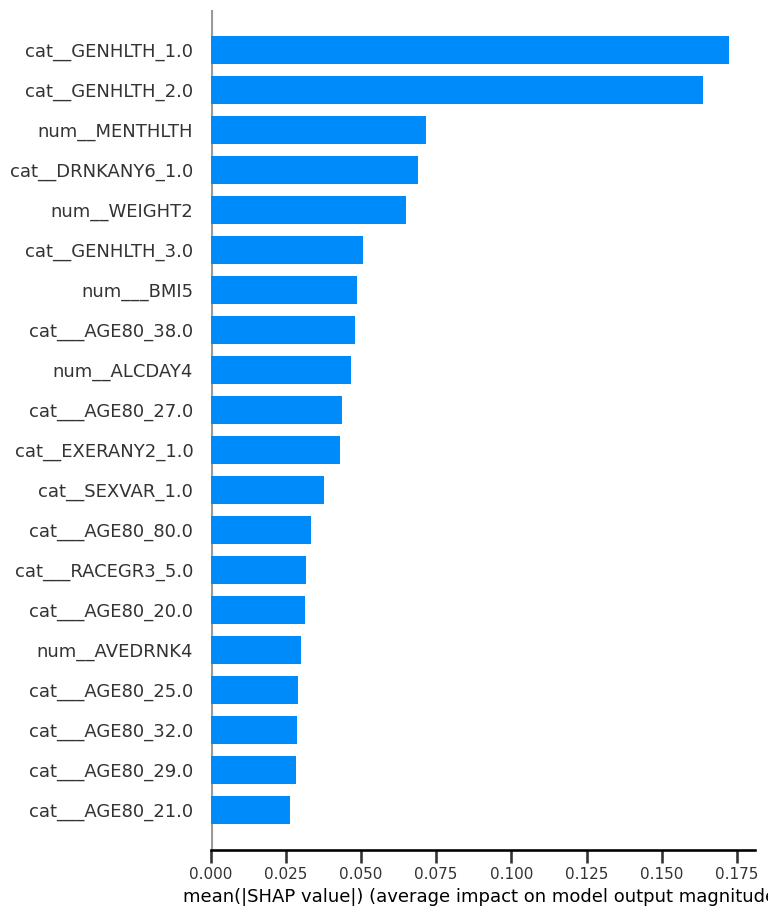

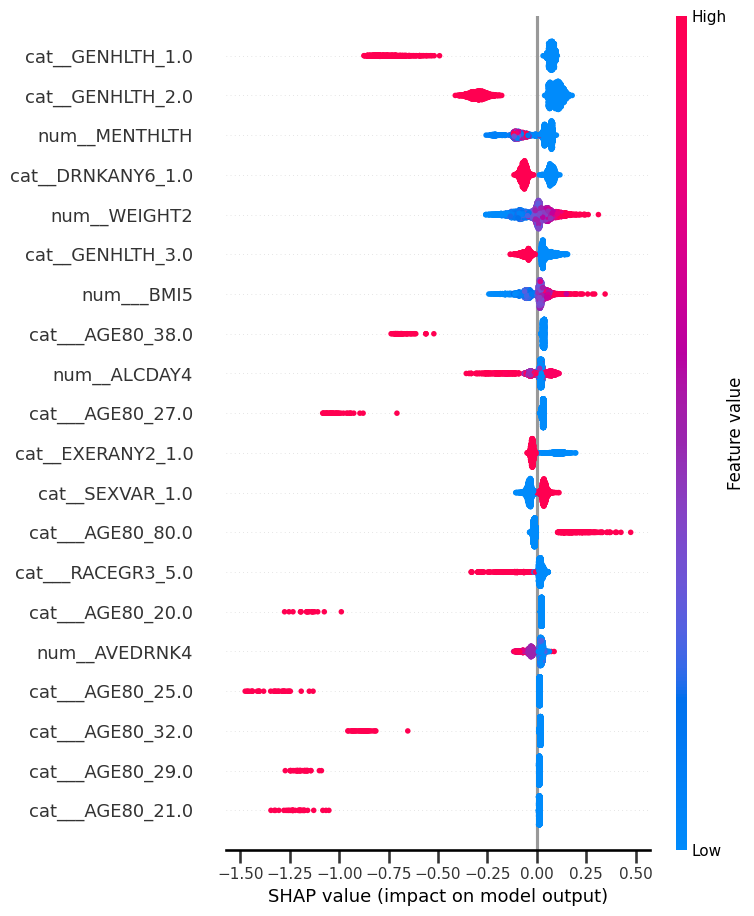

In [27]:
# 22. Global SHAP Summary Plots (Top Predictors) - FAST

# Compute SHAP on a sample of X2_test
X2_eval, explainer2, values2 = shap_fast_model2(
    xgb2, X2_test,
    class_index=2,    # Diabetes class
    bg_size=1000,
    eval_size=3000,
    random_state=101
)

# Bar & dot summary on the sampled data
shap.summary_plot(values2, X2_eval, plot_type="bar", max_display=20)
shap.summary_plot(values2, X2_eval, plot_type="dot", max_display=20)


# 23. Local SHAP Force Plots (Individual Cases)

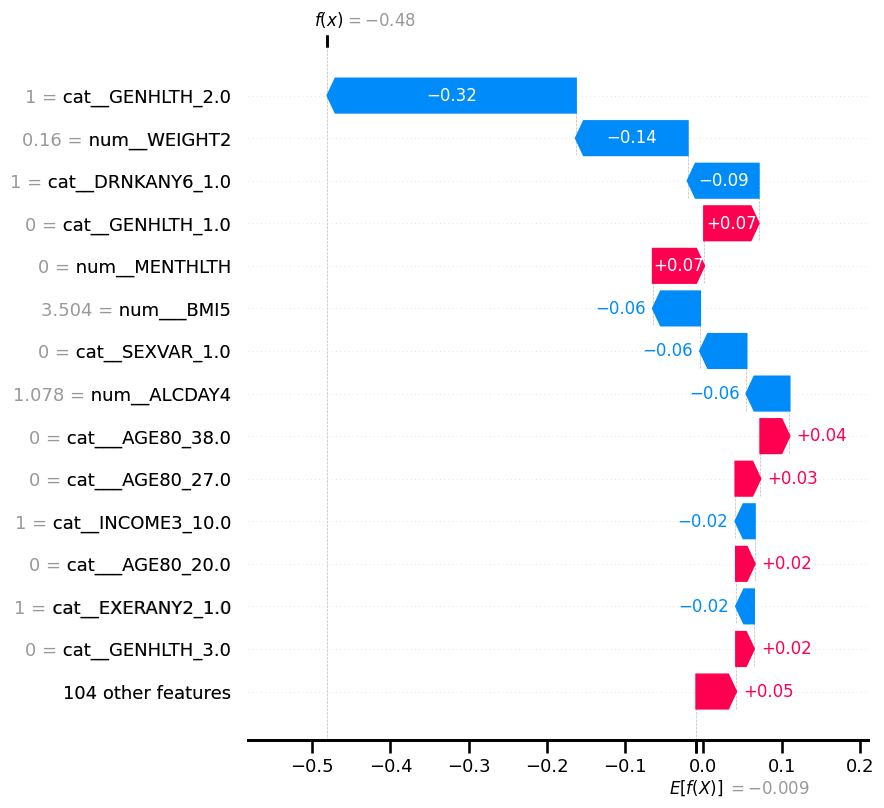

In [29]:
import shap

i = 0  # choose a row in X2_eval
exp = shap.Explanation(
    values=values2[i, :],
    base_values=explainer2.expected_value[2],
    data=X2_eval.iloc[i, :],
    feature_names=X2_eval.columns,
)

shap.waterfall_plot(exp, max_display=15)


# 24. SHAP Aggregation: Behavioral vs Non-Behavioral

Proportion of total |SHAP| by group (sample-based):


,mean_abs_shap
group,
Behavioral,0.48323
Non-behavioral\n(Demo + Anthro),0.51677


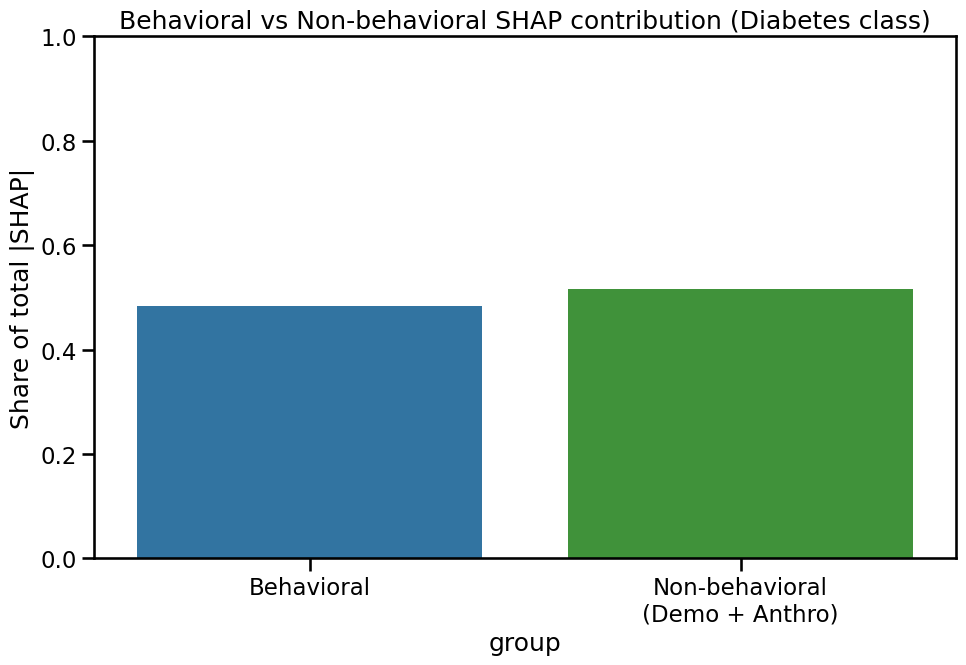

In [38]:
# 24. SHAP Aggregation: Behavioral vs Non-Behavioral (FAST, Model-2)

behavioral_keys = [
    "EXERANY2","GENHLTH","PHYSHLTH","PHYS14D","MENTHLTH","POORHLTH",
    "ALCDAY4","AVEDRNK4","DRNK","DRNKANY6",
    "SMOKE100","SMOKDAY2","_SMOKER3","_RFSMOK3"
]

# Mean |SHAP| per feature on the sample
mean_abs = np.abs(values2).mean(axis=0)
feat_df = pd.DataFrame({
    "feature": X2_eval.columns,
    "mean_abs_shap": mean_abs
})

def assign_group(col):
    if any(k in col for k in behavioral_keys):
        return "Behavioral"
    else:
        return "Non-behavioral\n(Demo + Anthro)"

feat_df["group"] = feat_df["feature"].apply(assign_group)

group_sum = feat_df.groupby("group")["mean_abs_shap"].sum()
group_prop = group_sum / group_sum.sum()

print("Proportion of total |SHAP| by group (sample-based):")
display(group_prop)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.barplot(x=group_prop.index, y=group_prop.values, palette=["#1f78b4", "#33a02c"])
plt.ylabel("Share of total |SHAP|")
plt.ylim(0, 1)
plt.title("Behavioral vs Non-behavioral SHAP contribution (Diabetes class)")
plt.tight_layout()
plt.show()


# 25. State-level Mean SHAP Heatmap (Model-2, Diabates class)

It visualizes how the average behavioral + demographic + anthropometric contributions (from Model-2) vary geographically across U.S. states for the diabetes (= 2) class.

This cell aggregates SHAP values by State_Name and plots a heatmap.
It lets readers see regional patterns (e.g., higher behavioral-risk impact in southern states, lower in northern ones).

Mean total |SHAP| per state (sample-based):


,total_abs_shap
State,
South Dakota,1.767231
District of Columbia,1.748263
Rhode Island,1.744164
Mississippi,1.719463
Guam,1.700329
Georgia,1.700186
Oregon,1.676135
New York,1.675296
Hawaii,1.670113


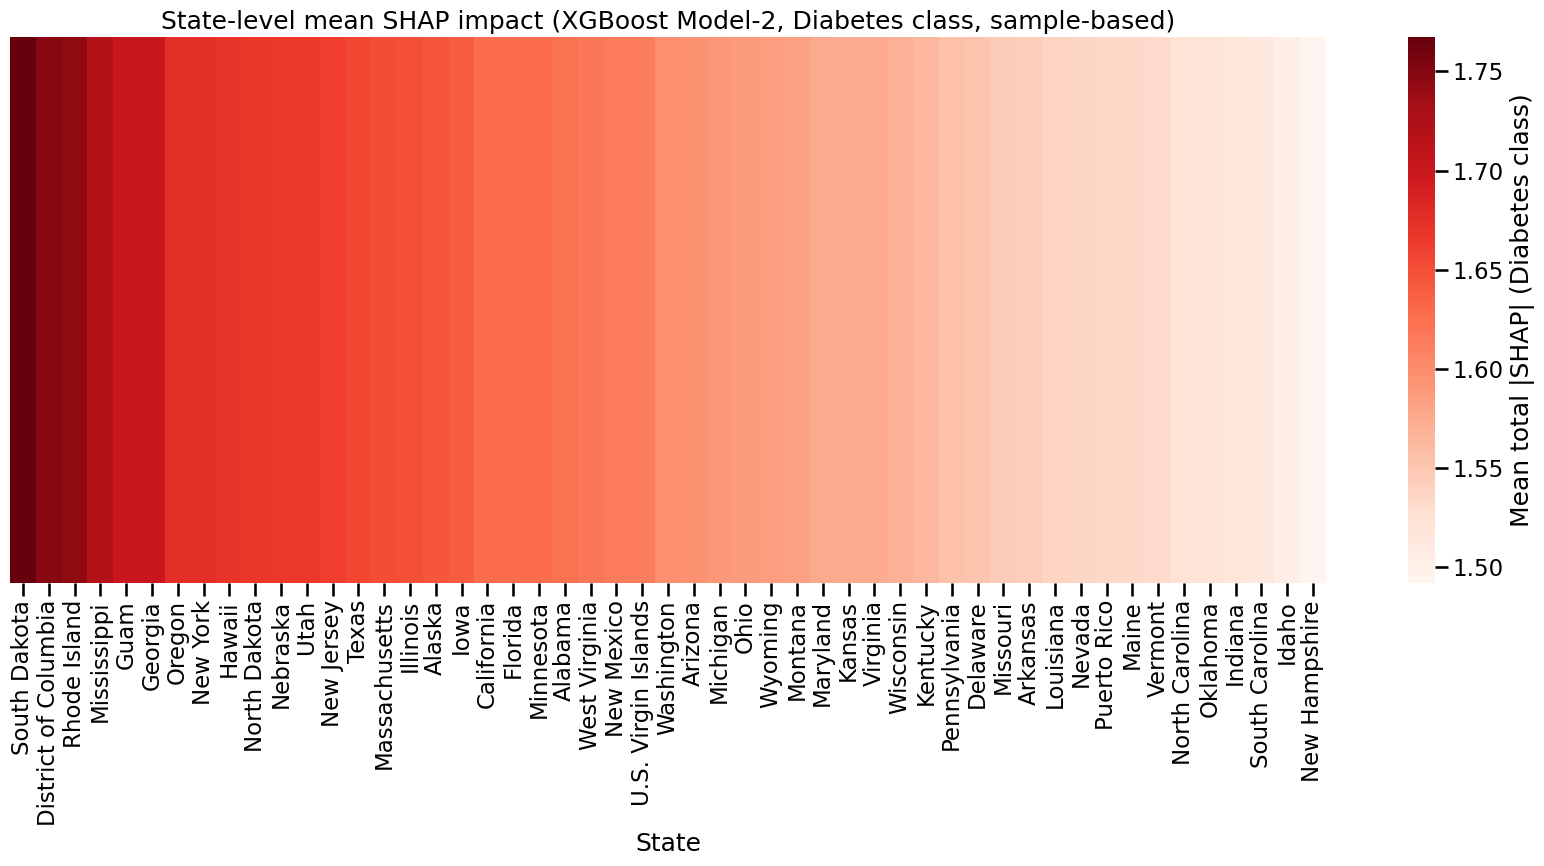

In [36]:
# 25. State-level Mean SHAP Heatmap (FAST, Model-2, Diabetes class)

# state_test should be aligned with X2_test index
# If you don't have it yet, construct it as:
state_test = state_series.loc[X2_test.index]

# Get state labels only for the sampled eval rows
state_eval = state_test.loc[X2_eval.index]

# Total |SHAP| per sample (sum over features)
total_abs_per_sample = np.abs(values2).sum(axis=1)

state_shap_df = pd.DataFrame({
    "State": state_eval.values,
    "total_abs_shap": total_abs_per_sample
})

state_mean = (
    state_shap_df
    .groupby("State")["total_abs_shap"]
    .mean()
    .sort_values(ascending=False)
)

print("Mean total |SHAP| per state (sample-based):")
display(state_mean.head(10))

# 1D heatmap (states on x-axis)
plt.figure(figsize=(17, 9))
sns.heatmap(
    state_mean.to_frame().T,
    cmap="Reds",
    cbar_kws={"label": "Mean total |SHAP| (Diabetes class)"},
    xticklabels=True,
    yticklabels=False
)
plt.xticks(rotation=90)
plt.title("State-level mean SHAP impact (XGBoost Model-2, Diabetes class, sample-based)")
plt.tight_layout()
plt.show()
